In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os


# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ventilator-pressure-prediction/sample_submission.csv
/kaggle/input/ventilator-pressure-prediction/train.csv
/kaggle/input/ventilator-pressure-prediction/test.csv


**Basic Libraries**

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import missingno as msno

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from lightgbm import LGBMRegressor

from sklearn.metrics import r2_score, accuracy_score, roc_auc_score


import warnings
warnings.filterwarnings('ignore')

In [ ]:
def mape(actual, pred):
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / actual)) * 100

**Importing Dataset**

In [ ]:
data_train = pd.read_csv('../input/ventilator-pressure-prediction/train.csv')
data_test = pd.read_csv('../input/ventilator-pressure-prediction/test.csv')

# Data Processing

In [ ]:
data_train.head()

,id,breath_id,R,C,time_step,u_in,u_out,pressure
0,1,1,20,50,0.000000,0.083334,0,5.837492
1,2,1,20,50,0.033652,18.383041,0,5.907794
2,3,1,20,50,0.067514,22.509278,0,7.876254
3,4,1,20,50,0.101542,22.808822,0,11.742872
4,5,1,20,50,0.135756,25.355850,0,12.234987


In [ ]:
data_test.head()

,id,breath_id,R,C,time_step,u_in,u_out
0,1,0,5,20,0.000000,0.000000,0
1,2,0,5,20,0.031904,7.515046,0
2,3,0,5,20,0.063827,14.651675,0
3,4,0,5,20,0.095751,21.230610,0
4,5,0,5,20,0.127644,26.320956,0


**Feature Description**

|Features|Description|
|:-------:|:----------|
|id|Globally-unique time step identifier across an entire file|
|breath_id|Globally-unique time step for breaths|
|R|Lung attribute indicating how restricted the airway is (in cmH2O/L/S). Physically, this is the change in pressure per change in flow (air volume per time). Intuitively, one can imagine blowing up a balloon through a straw. We can change R by changing the diameter of the straw, with higher R being harder to blow.|
|C|Lung attribute indicating how compliant the lung is (in mL/cmH2O). Physically, this is the change in volume per change in pressure. Intuitively, one can imagine the same balloon example. We can change C by changing the thickness of the balloon’s latex, with higher C having thinner latex and easier to blow.|
|time_step|The actual time stamp.|
|u_in|The control input for the inspiratory solenoid valve. Ranges from 0 to 100.|
|u_out|The control input for the exploratory solenoid valve. Either 0 or 1.|
|pressure|The airway pressure measured in the respiratory circuit, measured in cmH2O.|

In [ ]:
sha = pd.DataFrame({'Rows':[data_train.shape[0],data_test.shape[0]], 'Columns':[data_train.shape[1], data_test.shape[1]]},
                  index = ['Train Dataset', 'Test Dataset'])
sha

,Rows,Columns
Train Dataset,6036000,8
Test Dataset,4024000,7


In [ ]:
data_train.info()
print('====================================')
data_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6036000 entries, 0 to 6035999
Data columns (total 8 columns):
 #   Column     Dtype  
---  ------     -----  
 0   id         int64  
 1   breath_id  int64  
 2   R          int64  
 3   C          int64  
 4   time_step  float64
 5   u_in       float64
 6   u_out      int64  
 7   pressure   float64
dtypes: float64(3), int64(5)
memory usage: 368.4 MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4024000 entries, 0 to 4023999
Data columns (total 7 columns):
 #   Column     Dtype  
---  ------     -----  
 0   id         int64  
 1   breath_id  int64  
 2   R          int64  
 3   C          int64  
 4   time_step  float64
 5   u_in       float64
 6   u_out      int64  
dtypes: float64(2), int64(5)
memory usage: 214.9 MB


**Missing Values**

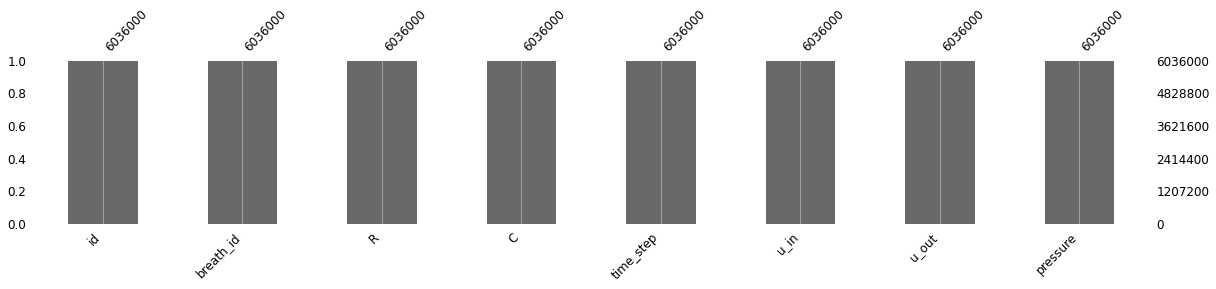

In [ ]:
msno.bar(data_train, figsize = (20,3), fontsize = 12)
plt.grid();

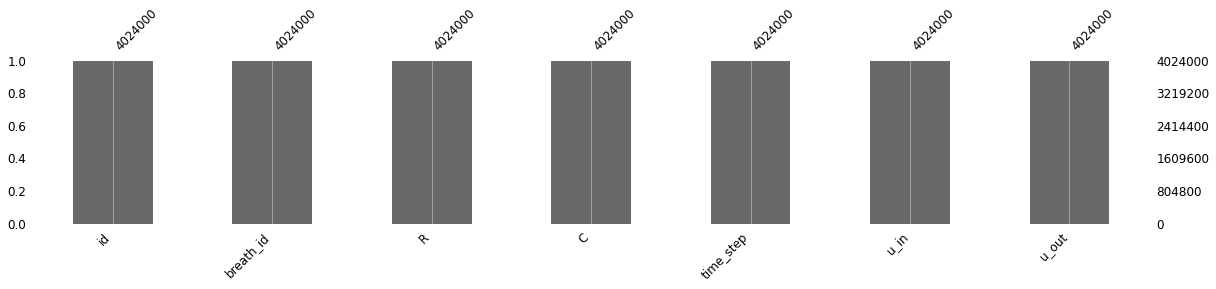

In [ ]:
msno.bar(data_test, figsize=(20,3),fontsize=12)
plt.grid();

No Missing Values are observed in both Train and Test Datasets.

**Duplicate Records**

In [ ]:
dupstr = data_train.duplicated()
print('Total no of duplicate values in Training Dataset = %d' % (dupstr.sum()))

data_train[dupstr]

Total no of duplicate values in Training Dataset = 0


,id,breath_id,R,C,time_step,u_in,u_out,pressure


In [ ]:
dupstst = data_test.duplicated()
print('Total no of duplicate values in Test Dataset = %d' % (dupstst.sum()))

data_test[dupstst]

Total no of duplicate values in Test Dataset = 0


,id,breath_id,R,C,time_step,u_in,u_out


# Exploratory Data Analysis

In [ ]:
DF_train = data_train.copy()
DF_train.drop(['id', 'breath_id'], axis = 1, inplace = True)

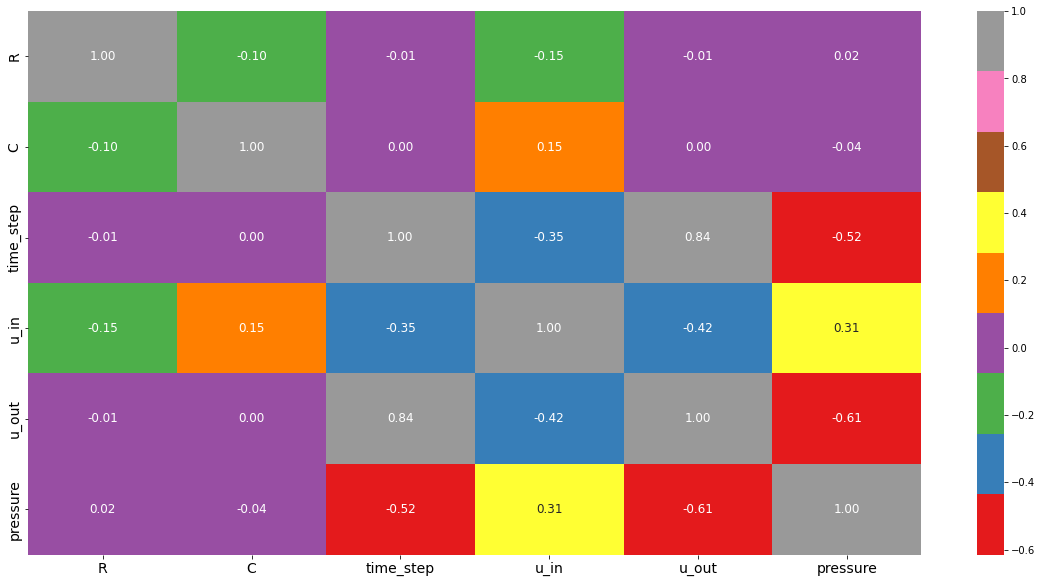

In [ ]:
plt.figure(figsize = (20,10))
sns.heatmap(DF_train.corr(), annot = True, fmt = '3.2f' , annot_kws={'size' : 12}, cmap="Set1")
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.show()

* Only the control input for the exploratory solenoid valve i.e. u_out, showing high positive correlation with time and moderately negative correlation to Pressure.
* u_in has good positive correlation with pressure.

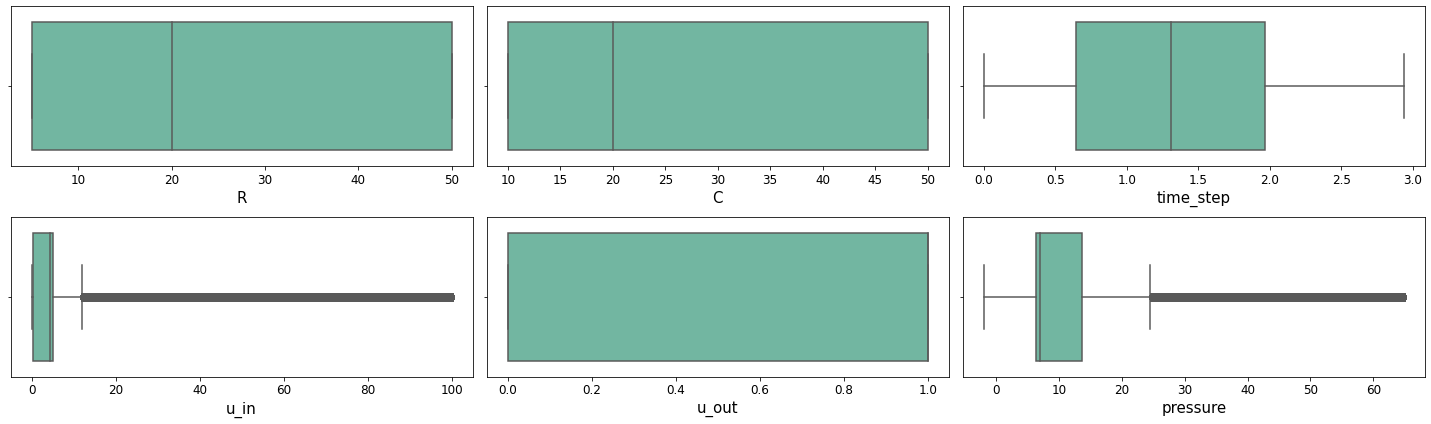

In [ ]:
a = 2
b = 3
c = 1

plt.figure(figsize = (20,6))
for col in DF_train.columns:
    plt.subplot(a,b,c)
    sns.boxplot(DF_train[col], palette='Set2')
    plt.xlabel('{}'.format(col), fontsize = 15)
    plt.xticks(fontsize = 12)

    c = c+1

plt.tight_layout()

In [ ]:
data_train.time_step.value_counts()

0.000000    75450
0.031934       46
0.031935       44
0.031920       43
0.031938       43
            ...  
1.793088        1
1.827272        1
1.896594        1
1.930891        1
2.638017        1
Name: time_step, Length: 3767571, dtype: int64

In [ ]:
unique_breaths = len(data_train.breath_id.unique())
print("No of Breaths:", unique_breaths)

breath_length = data_train.groupby('breath_id').C.count().unique()
if len(breath_length) == 1:
    breath_length = breath_length[0]
print("Breath Length:", breath_length)

No of Breaths: 75450
Breath Length: 80


In [ ]:
r_c_variance = data_train.groupby('breath_id')[['R','C']].var()
r_c_variance

,R,C
breath_id,,
1,0.0,0.0
2,0.0,0.0
3,0.0,0.0
4,0.0,0.0
5,0.0,0.0
...,...,...
125740,0.0,0.0
125742,0.0,0.0
125743,0.0,0.0


* For each breath R and C values are constant

In [ ]:
R_value = data_train[['breath_id', 'R']].groupby('breath_id').mean()['R']
print('Unique change in pressure per change in air flow:')
print(R_value.value_counts())
R = np.sort(R_value.unique()).astype(int)

Unique change in pressure per change in air flow:
50.0    30126
5.0     24860
20.0    20464
Name: R, dtype: int64


In [ ]:
C_value = data_train[['breath_id', 'C']].groupby('breath_id').mean()['C']
print('Change in volume per change in pressure:')
print(C_value.value_counts())
C = np.sort(C_value.unique()).astype(int)

Change in volume per change in pressure:
10.0    28059
50.0    24646
20.0    22745
Name: C, dtype: int64


**R_C combinations**

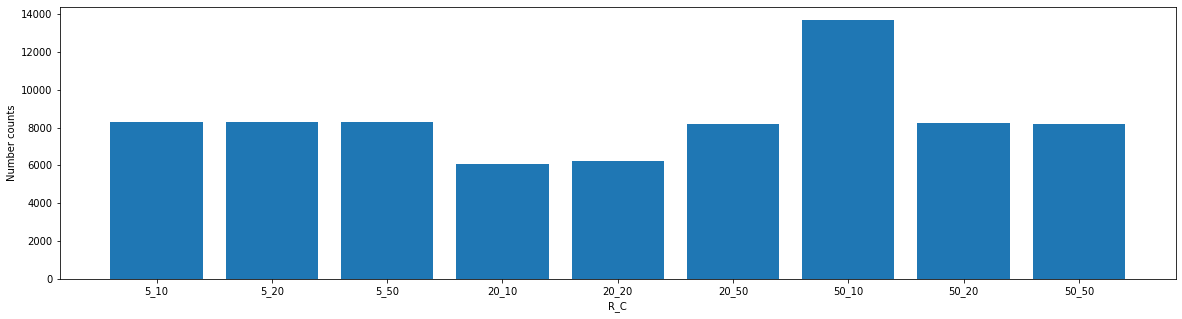

In [ ]:
rc_values = np.array([
    [r, c, len(data_train[(data_train['R'] == r) & (data_train['C'] == c)])//breath_length]
    for r in R
    for c in C
])
x = range(len(rc_values))
plt.figure(figsize = (20,5))
plt.bar(x, rc_values[:,2])
plt.xticks(x, [str(r) + '_' + str(c) for r, c in rc_values[:,:2] ])
plt.xlabel('R_C')
plt.ylabel('Number counts')
plt.show()

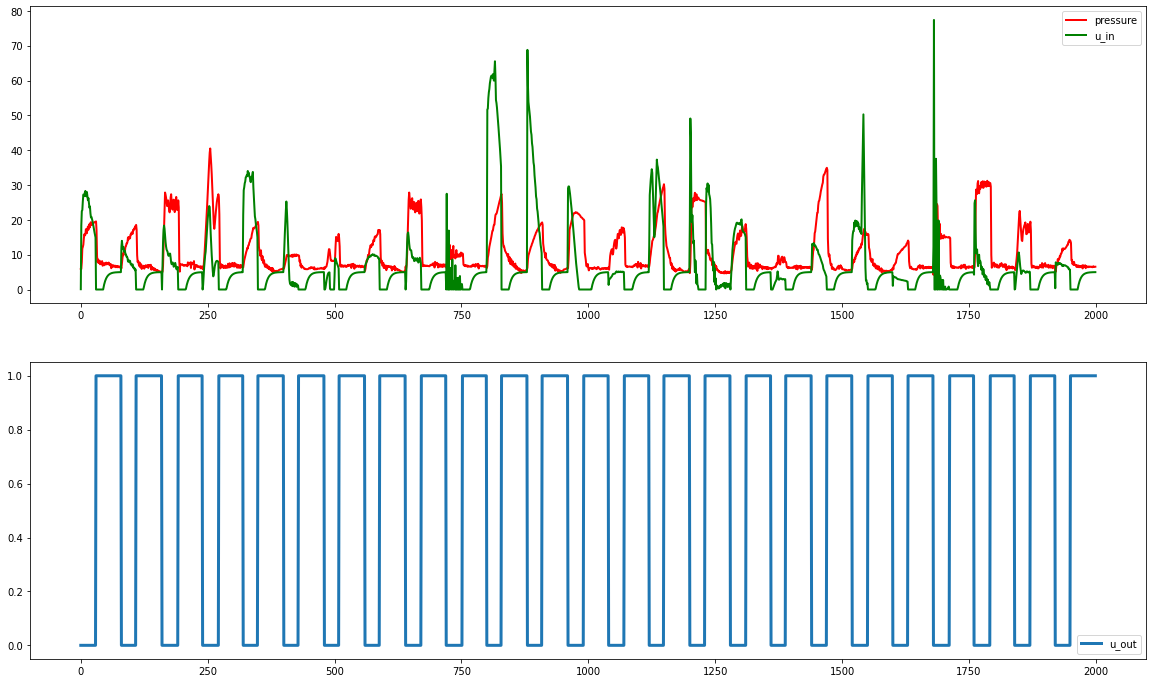

In [ ]:
plt.figure(figsize = (20,12))
plt.subplot(211)
plt.plot(data_train.pressure[:2000], linewidth = 2, color = 'r', label="pressure")
plt.plot(data_train.u_in[:2000], linewidth = 2, color = 'g', label="u_in")
plt.legend()
plt.subplot(212)
plt.plot(data_train.u_out[:2000], linewidth = 3, label="u_out")
plt.legend()

plt.show()

* Pressure rises when u_out=0, then drops when u_out=1
* u_in have a irregular pattern and somehow correlate to pressure.

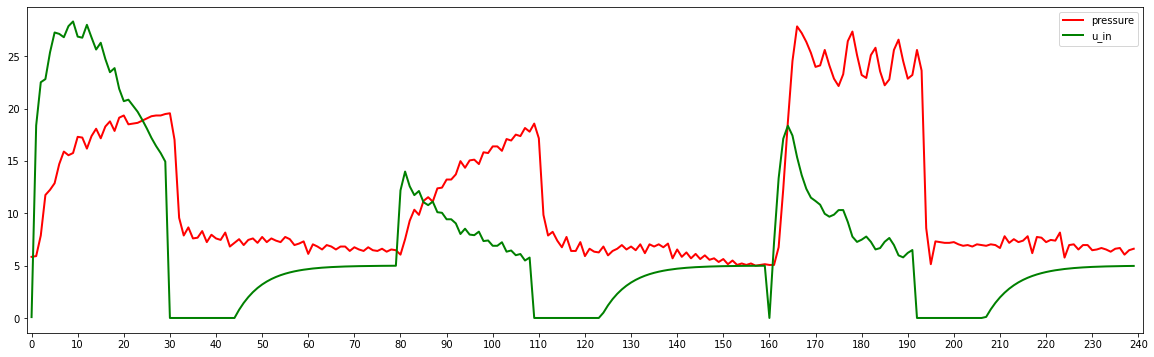

In [ ]:
plt.figure(figsize = (20,6))
plt.plot(data_train.pressure[:240], linewidth = 2, color = 'r', label="pressure")
plt.plot(data_train.u_in[:240], linewidth = 2, color = 'g', label="u_in")
plt.xticks(np.arange(0, 241, 10))
plt.xlim([-1, 241])
plt.legend()
plt.show()

* Each breath cycle is 80 unit long.
* In every cycle, u_in raise shape at 0 and the start decreasing. At 30 it falls sharp to 0 are remains at same from 30 to 45 unit and then raise exponentially and become constant till the end of the each breath cycle.
* Pressure raise when u_in triggered. It falls sharp after the fall of u_in to 0.
* The pressure does not fall to 0 rather it hold the memory till the next trigger of u_in.

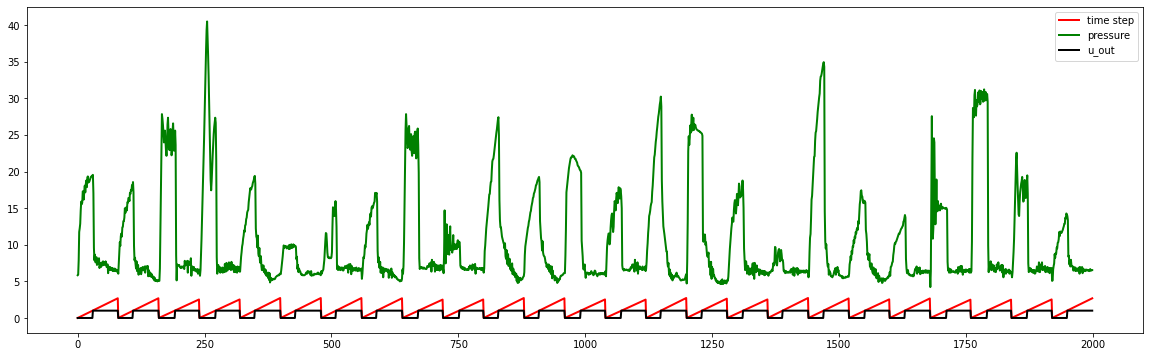

In [ ]:
plt.figure(figsize = (20,6))
plt.plot(data_train.time_step[:2000], linewidth = 2, color = 'r', label="time step")
plt.plot(data_train.pressure[:2000], linewidth = 2, color = 'g', label="pressure")
plt.plot(data_train.u_out[:2000], linewidth = 2, color = 'k', label="u_out")
plt.legend()
plt.legend()

plt.show()

**Select Input and Target Feature**

|Features|Importance Level for the Target Prediction|
|:-------:|:----------|
|id|This feature is irrelevant in pressure prediction|
|breath_id|Helps to identify the events, but not relevant for pressure prediction|
|R|For each breath cycle the R remains constant, no variation has been traced, so we should not consider it as necessary feature.|
|C|The similar parrten observed as in R, hence not considered as the required features for the |
|time_step|This feature also not significant for the prediction of target|
|u_in|The only **major feature** that correlate to the pressure.|
|u_out|Behaves like a **switch** in the generation of pressure|

In [ ]:
dataTrn = data_train.copy()
dataTrn.drop(columns=['id', 'breath_id', 'R', 'C', 'time_step'], axis = 1, inplace = True)

In [ ]:
X = dataTrn.drop(columns='pressure')
X = X[:80000]
y = dataTrn['pressure']
y = y[:80000]

In [ ]:
X_train, X_validation, y_train, y_validation = train_test_split(X, y, test_size=0.30, random_state=1)
print('Dimension of X_train:', X_train.shape,'\nDimension of X_validation:', X_validation.shape,'\nDimension of y_train:', y_train.shape,'\nDimension of y_validation:', y_validation.shape)

Dimension of X_train: (56000, 2) 
Dimension of X_validation: (24000, 2) 
Dimension of y_train: (56000,) 
Dimension of y_validation: (24000,)


# Building Model

### Linear Regression

In [ ]:
LR_model = LinearRegression()
LR_model.fit(X_train, y_train)

LinearRegression()

In [ ]:
LR_train_predict = LR_model.predict(X_train)
LR_validation_predict = LR_model.predict(X_validation)

<span style='color:Brown'>**Model Evaluation metrics**</span>

In [ ]:
LR_R2_train = r2_score(y_train,LR_train_predict)
LR_R2_validation = r2_score(y_validation,LR_validation_predict)

LR_MAPE_train = mape(y_train,LR_train_predict)
LR_MAPE_validation = mape(y_validation,LR_validation_predict)


In [ ]:
resultsLR = pd.DataFrame({'R Squared Score': LR_R2_validation,
                          'MAPE Score':LR_MAPE_validation }
                           ,index=['Linear Regression'])

resultsLR

,R Squared Score,MAPE Score
Linear Regression,0.380519,37.565245


### Light Gradient Boosted Machine Regressor

In [ ]:
LGBMR_model = make_pipeline(StandardScaler(), LGBMRegressor(n_estimators=501))
LGBMR_model.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('lgbmregressor', LGBMRegressor(n_estimators=501))])

In [ ]:
LGBMR_train_predict = LGBMR_model.predict(X_train)
LGBMR_validation_predict = LGBMR_model.predict(X_validation)

<span style='color:Brown'>**Model Evaluation metrics**</span>

In [ ]:
LGBMR_R2_train = r2_score(y_train,LGBMR_train_predict)
LGBMR_R2_validation = r2_score(y_validation,LGBMR_validation_predict)

LGBMR_MAPE_train = mape(y_train,LGBMR_train_predict)
LGBMR_MAPE_validation = mape(y_validation,LGBMR_validation_predict)

In [ ]:
resultsLGBMR = pd.DataFrame({'R Squared Score': LGBMR_R2_validation,
                          'MAPE Score':LGBMR_MAPE_validation }
                           ,index=['Light Gradient Boosted Machine'])

results2 = pd.concat([resultsLGBMR,resultsLR])
results2

,R Squared Score,MAPE Score
Light Gradient Boosted Machine,0.443025,34.115820
Linear Regression,0.380519,37.565245


### Random Forest Regressor

In [ ]:
RF_model=RandomForestRegressor(n_estimators = 501, random_state=0)
RF_model.fit(X_train, y_train)

RandomForestRegressor(n_estimators=501, random_state=0)

In [ ]:
RF_train_predict = RF_model.predict(X_train)
RF_validation_predict = RF_model.predict(X_validation)

<span style='color:Brown'>**Model Evaluation metrics**</span>

In [ ]:
RF_R2_train = r2_score(y_train,RF_train_predict)
RF_R2_validation = r2_score(y_validation,RF_validation_predict)

RF_MAPE_train = mape(y_train,RF_train_predict)
RF_MAPE_validation = mape(y_validation,RF_validation_predict)

In [ ]:
resultsRF = pd.DataFrame({'R Squared Score': RF_R2_validation,
                          'MAPE Score':RF_MAPE_validation }
                           ,index=['Random Forest'])

results3 = pd.concat([resultsRF,results2])
results3

,R Squared Score,MAPE Score
Random Forest,0.295020,36.808463
Light Gradient Boosted Machine,0.443025,34.115820
Linear Regression,0.380519,37.565245


### XGBoost Regressor

In [ ]:
XGB_model = XGBRegressor()
XGB_model.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=2,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [ ]:
XGB_train_predict = XGB_model.predict(X_train)
XGB_validation_predict = XGB_model.predict(X_validation)

<span style='color:Brown'>**Model Evaluation metrics**</span>

In [ ]:
XGB_R2_train = r2_score(y_train,XGB_train_predict)
XGB_R2_validation = r2_score(y_validation,XGB_validation_predict)

XGB_MAPE_train = mape(y_train,XGB_train_predict)
XGB_MAPE_validation = mape(y_validation,XGB_validation_predict)

In [ ]:
resultsXGB = pd.DataFrame({'R Squared Score': XGB_R2_validation,
                          'MAPE Score':XGB_MAPE_validation }
                           ,index=['XGBoost Regressor'])

results4 = pd.concat([resultsXGB,results3])
results4

,R Squared Score,MAPE Score
XGBoost Regressor,0.434124,34.245190
Random Forest,0.295020,36.808463
Light Gradient Boosted Machine,0.443025,34.115820
Linear Regression,0.380519,37.565245


# Verdict

Light Gradient Boosted Machine Regressor has been considered as it shows highest R2 value among all the tested models.

In [ ]:
Submission = pd.read_csv('../input/ventilator-pressure-prediction/sample_submission.csv')

In [ ]:
data_test.drop(columns=['id', 'breath_id', 'R', 'C', 'time_step'], axis = 1, inplace = True)

In [ ]:
Final_Prediction = LGBMR_model.predict(data_test)

**Saving the Prediction**

In [ ]:
Submission.pressure = Final_Prediction

In [ ]:
Submission.head()

,id,pressure
0,1,21.742664
1,2,16.400895
2,3,19.790988
3,4,19.720637
4,5,21.090335
